In [316]:
import numpy as np
from skimage.morphology import erosion, dilation, binary_erosion, opening, closing, white_tophat, reconstruction, black_tophat, skeletonize, convex_hull_image, thin
from skimage.morphology import square, diamond, octagon, rectangle, star, disk
from skimage.filters.rank import entropy, enhance_contrast_percentile
from PIL import Image
from scipy import ndimage as ndi
from skimage.util import img_as_ubyte
import math
from skimage import data, filters
from matplotlib import pyplot as plt

In [317]:
def my_segmentation(img, img_mask, seuil):
    img_out = (img_mask & (img < seuil))
    return img_out

def evaluate(img_out, img_GT):
    GT_skel  = thin(img_GT) # On suppose que la demie epaisseur maximum 
    img_out_skel  = thin(img_out) # d'un vaisseau est de 15 pixels...
    TP = np.sum(img_out_skel & img_GT) # Vrais positifs
    FP = np.sum(img_out_skel & ~img_GT) # Faux positifs
    FN = np.sum(GT_skel & ~img_out) # Faux negatifs

    ACCU = TP / (TP + FP) # Precision
    RECALL = TP / (TP + FN) # Rappel
    return ACCU, RECALL, img_out_skel, GT_skel


In [318]:
#Ouvrir l'image originale en niveau de gris
img =  np.asarray(Image.open('./images_IOSTAR/star01_OSC.jpg')).astype(np.uint8)
print(img.shape)

nrows, ncols = img.shape
row, col = np.ogrid[:nrows, :ncols]
#On ne considere que les pixels dans le disque inscrit 
img_mask = (np.ones(img.shape)).astype(np.bool_)
invalid_pixels = ((row - nrows/2)**2 + (col - ncols/2)**2 > (nrows / 2)**2)
img_mask[invalid_pixels] = 0

img_out = my_segmentation(img,img_mask,80)

(512, 512)


In [319]:
# Open the Ground Truth image as a boolean array
img_GT = np.asarray(Image.open('./images_IOSTAR/GT_01.png')).astype(np.bool_)

# Call the evaluate function without specifying the max_iter argument
ACCU, RECALL, img_out_skel, GT_skel = evaluate(img_out, img_GT)
print('Accuracy =', ACCU, ', Recall =', RECALL)


Accuracy = 0.26275272161741836 , Recall = 0.6554801163918526


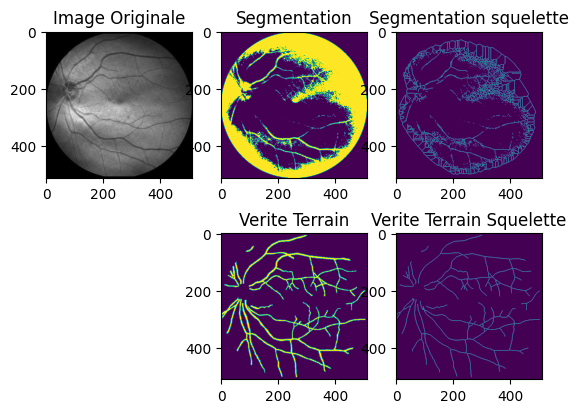

In [320]:
plt.subplot(231)
plt.imshow(img,cmap = 'gray')
plt.title('Image Originale')
plt.subplot(232)
plt.imshow(img_out)
plt.title('Segmentation')
plt.subplot(233)
plt.imshow(img_out_skel)
plt.title('Segmentation squelette')
plt.subplot(235)
plt.imshow(img_GT)
plt.title('Verite Terrain')
plt.subplot(236)
plt.imshow(GT_skel)
plt.title('Verite Terrain Squelette')
plt.show()

In [321]:
import matplotlib.pyplot as plt
from skimage import data
from skimage.filters import threshold_otsu

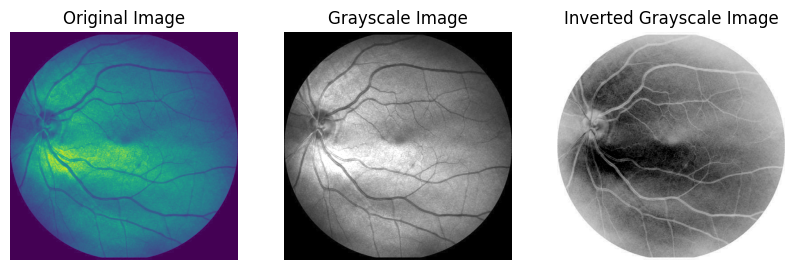

In [322]:
from PIL import Image,ImageOps
import numpy as np
import matplotlib.pyplot as plt
# Load the original image
img = np.asarray(Image.open('./images_IOSTAR/star01_OSC.jpg')).astype(np.uint8)
# Contrast stretching
p1, p99 = np.percentile(img, (1, 99))
img_rescale = exposure.rescale_intensity(img, in_range=(p1, p99)) # read the documentation of rescale_intensity
img_rescale=img_rescale.astype(np.uint8) # I convert the image and put it into 8 bits
img_pil =Image.fromarray(img_rescale) # I convert from a numpy array to a Pil image
# Convert the image to grayscale
gray_img = img_pil.convert('L')

# Invert the grayscale image
inverted_gray_img = ImageOps.invert(gray_img)

# Create a figure and axes to display the images
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

# Display the original image
axes[0].imshow(img)
axes[0].set_title('Original Image')

# Display the grayscale image
axes[1].imshow(gray_img, cmap='gray')
axes[1].set_title('Grayscale Image')

axes[2].imshow(inverted_gray_img, cmap='gray')
axes[2].set_title('Inverted Grayscale Image')

# Hide the axes ticks
for ax in axes:
    ax.axis('off')

# Show the images
plt.show()

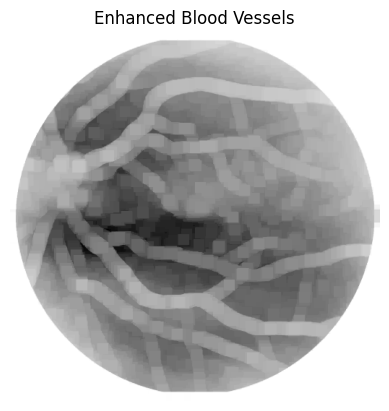

In [323]:
import numpy as np
from scipy import ndimage

# 定义结构元素
angles = [10*i for i in range(180)]  # 12个角度，每个相差15度
selem = np.zeros((15, 15))  # 15x15的结构元素
center = np.array(selem.shape) // 2  # 结构元素中心
for angle in angles:
    theta = np.deg2rad(angle)  # 将角度转换为弧度
    dx, dy = (np.cos(theta), np.sin(theta))
    line_points = center + np.array([dx, dy]) * np.array([-7, 7])[:, None]  # 小线段的两个端点
    line_points = line_points.astype(int).T
    rr, cc = line_points
    selem[rr, cc] = 1

# 对每个像素应用12个旋转后的结构元素，并取最大值
max_filtered = np.zeros_like(inverted_gray_img)
for angle in angles:
    selem_rotated = ndimage.rotate(selem, angle, reshape=False)
    filtered = ndimage.maximum_filter(inverted_gray_img, footprint=selem_rotated)
    max_filtered = np.maximum(max_filtered, filtered)

# 显示增强后的图像
plt.imshow(max_filtered, cmap='gray')
plt.title('Enhanced Blood Vessels')
plt.axis('off')
plt.show()


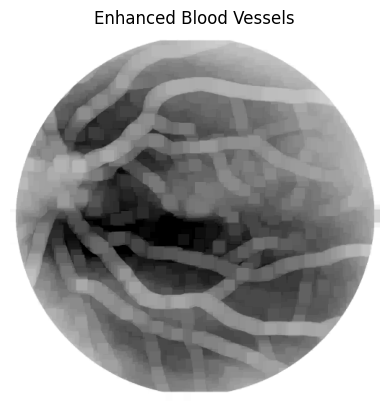

In [324]:
p1, p99 = np.percentile(max_filtered, (1, 99))
img_rescale = exposure.rescale_intensity(max_filtered, in_range=(p1, p99)) # read the documentation of rescale_intensity
img_rescale=img_rescale.astype(np.uint8) # I convert the image and put it into 8 bits
img_pil_max =Image.fromarray(img_rescale) # I convert from a numpy array to a Pil image
# 显示增强后的图像
plt.imshow(img_pil_max, cmap='gray')
plt.title('Enhanced Blood Vessels')
plt.axis('off')
plt.show()

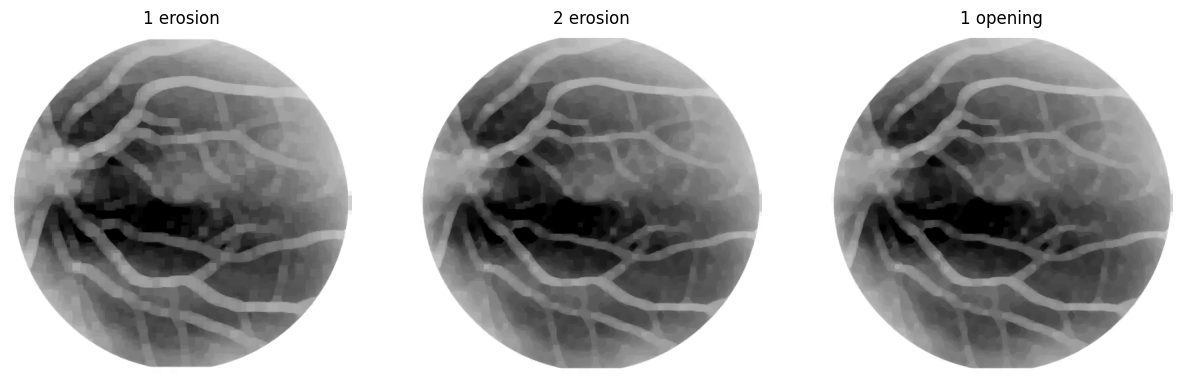

In [349]:
erosion1 = erosion(img_pil_max, disk(2))
erosion2 = erosion(erosion1, disk(2))
opening1 = opening(erosion2, disk(1))
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(erosion1, cmap='gray')
plt.title('1 erosion')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(erosion2, cmap='gray')
plt.title('2 erosion')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(opening1, cmap='gray')
plt.title('1 opening')
plt.axis('off')
plt.show()

In [326]:
import numpy as np

def uniform_filter(image, size):

    # 计算滤波器的半径
    radius = (size - 1) // 2
    
    # 创建一个与输入图像相同大小的零矩阵，用于存储平滑处理后的图像
    smoothed_image = np.zeros_like(image)
    
    # 应用均匀滤波器
    for i in range(radius, image.shape[0] - radius):
        for j in range(radius, image.shape[1] - radius):
            # 计算滤波器覆盖区域内的像素的平均值
            pixel_sum = 0
            for p in range(-radius, radius + 1):
                for q in range(-radius, radius + 1):
                    pixel_sum += image[i + p, j + q]
            smoothed_image[i, j] = pixel_sum / (size * size)
    
    return smoothed_image


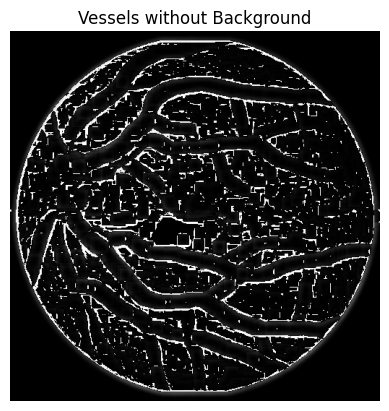

In [358]:
from scipy.ndimage import uniform_filter

# 定义背景图
background = uniform_filter(erosion1, size=10)

# 去除背景
vessel_only = img_pil_max - background

# 确保所有值都在0到255之间
vessel_only = np.clip(vessel_only, 0, 255)

# 显示去除背景后的图像
plt.imshow(vessel_only, cmap='gray')
plt.title('Vessels without Background')
plt.axis('off')
plt.show()


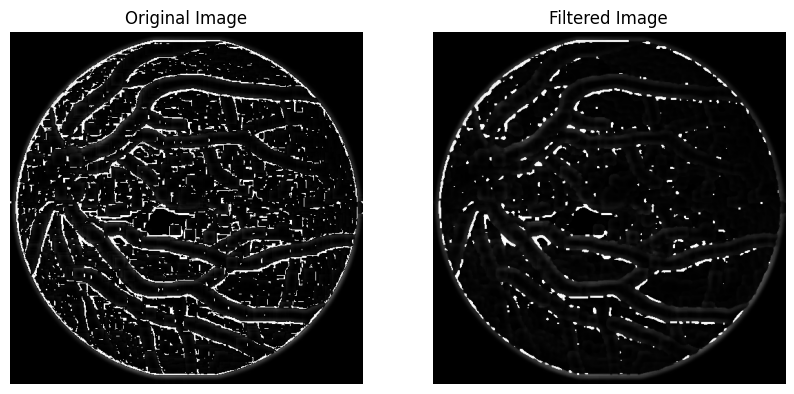

In [360]:
import cv2

# 应用中值滤波器进行滤波
filtered_image = cv2.medianBlur(vessel_only, 5)

# 显示原始图像和滤波后的图像
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(vessel_only, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(filtered_image, cmap='gray')
plt.title('Filtered Image')
plt.axis('off')

plt.show()

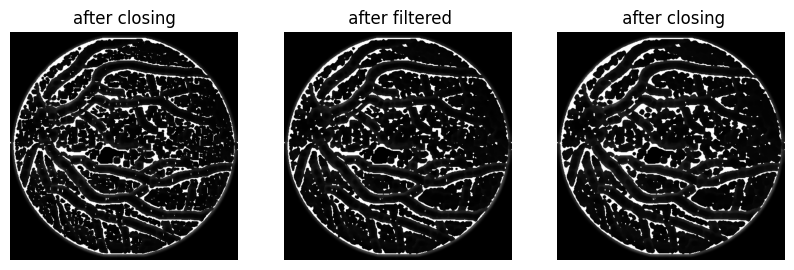

In [362]:
closing_filtered = closing(vessel_only, disk(3))
filtered_close = cv2.medianBlur(closing_filtered, 3)
close2 = closing(filtered_close, disk(4))
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(closing_filtered, cmap='gray')
plt.title('after closing')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(filtered_close, cmap='gray')
plt.title(' after filtered')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(close2, cmap='gray')
plt.title(' after closing')
plt.axis('off')

plt.show()

In [371]:
evaluate(filtered_close, img_GT)

(0.17513069454817026,
 0.15182907089673034,
 array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]))

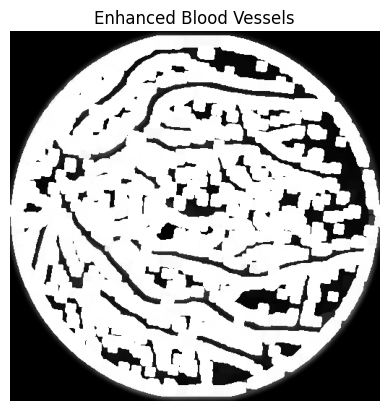

In [363]:
# 定义结构元素
angles = [10*i for i in range(180)]  # 12个角度，每个相差15度
selem = np.zeros((15, 15))  # 15x15的结构元素
center = np.array(selem.shape) // 2  # 结构元素中心
for angle in angles:
    theta = np.deg2rad(angle)  # 将角度转换为弧度
    dx, dy = (np.cos(theta), np.sin(theta))
    line_points = center + np.array([dx, dy]) * np.array([-7, 7])[:, None]  # 小线段的两个端点
    line_points = line_points.astype(int).T
    rr, cc = line_points
    selem[rr, cc] = 1

# 对每个像素应用12个旋转后的结构元素，并取最大值
max_filtered2 = np.zeros_like(close2)
for angle in angles:
    selem_rotated = ndimage.rotate(selem, angle, reshape=False)
    filtered = ndimage.maximum_filter(close2, footprint=selem_rotated)
    max_filtered2 = np.maximum(close2, filtered)

# 显示增强后的图像
plt.imshow(max_filtered2, cmap='gray')
plt.title('Enhanced Blood Vessels')
plt.axis('off')
plt.show()

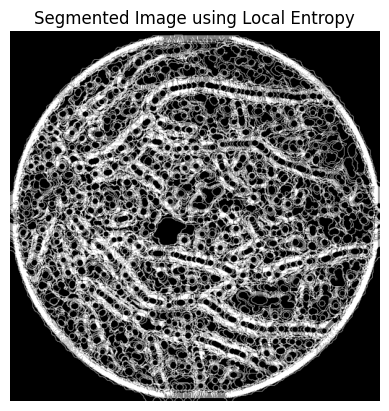

In [364]:
def local_entropy_threshold(image, window_size):
    height, width = image.shape[:2]
    entropy_image = np.zeros((height, width))

    # Iterate over each pixel in the image
    for y in range(height):
        for x in range(width):
            # Define the local window
            x_min = max(0, x - window_size // 2)
            x_max = min(width, x + window_size // 2)
            y_min = max(0, y - window_size // 2)
            y_max = min(height, y + window_size // 2)

            # Extract the local region
            local_region = image[y_min:y_max, x_min:x_max]

            # Compute the histogram
            hist, _ = np.histogram(local_region.flatten(), bins=256, range=[0, 256])

            # Compute probability distribution
            prob_dist = hist / np.sum(hist)

            # Compute entropy
            entropy = -np.sum(prob_dist * np.log2(prob_dist + 1e-10))  # Adding small value to avoid log(0)

            # Assign entropy to the corresponding pixel
            entropy_image[y, x] = entropy

    return entropy_image


# 定义局部熵的半径
radius = 2

# 计算局部熵
local_entropy = local_entropy_threshold(close2, radius)


# 显示分割结果
plt.imshow(local_entropy, cmap='gray')
plt.title('Segmented Image using Local Entropy')
plt.axis('off')
plt.show()

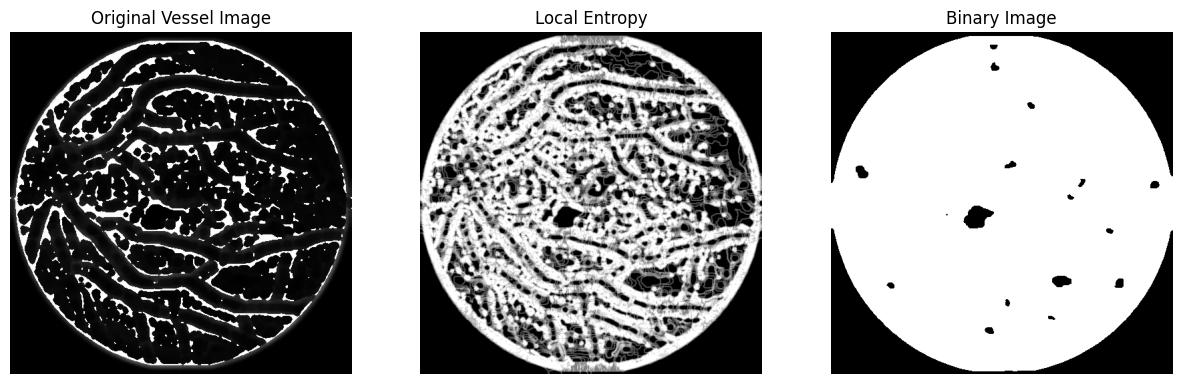

In [366]:
from scipy.ndimage import gaussian_filter
import skimage.filters as filters
import matplotlib.pyplot as plt

# 使用高斯滤波进行图像去噪
denoised_vessel_only = gaussian_filter(close2, sigma=1)

# 使用局部熵分割进行特征提取
local_entropy = filters.rank.entropy(denoised_vessel_only, np.ones((3, 3)))

# 使用局部熵分割进行二值化
threshold = 0.5 * np.max(local_entropy)  # 使用局部熵的阈值
binary_image = denoised_vessel_only > threshold

# 显示结果
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(close2, cmap='gray')
axes[0].set_title('Original Vessel Image')
axes[0].axis('off')

axes[1].imshow(local_entropy, cmap='gray')
axes[1].set_title('Local Entropy')
axes[1].axis('off')

axes[2].imshow(binary_image, cmap='gray')
axes[2].set_title('Binary Image')
axes[2].axis('off')

plt.show()


In [369]:
evaluate(filtered_close, img_GT)

(0.17513069454817026,
 0.15182907089673034,
 array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]))

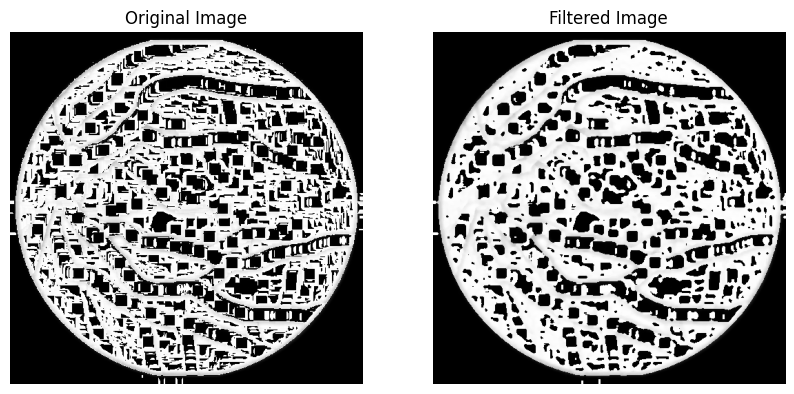

In [335]:
import cv2

# 应用中值滤波器进行滤波
filtered_image = cv2.medianBlur(vessel_only, 5)  # 使用5x5的核进行中值滤波

# 显示原始图像和滤波后的图像
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(vessel_only, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(filtered_image, cmap='gray')
plt.title('Filtered Image')
plt.axis('off')

plt.show()

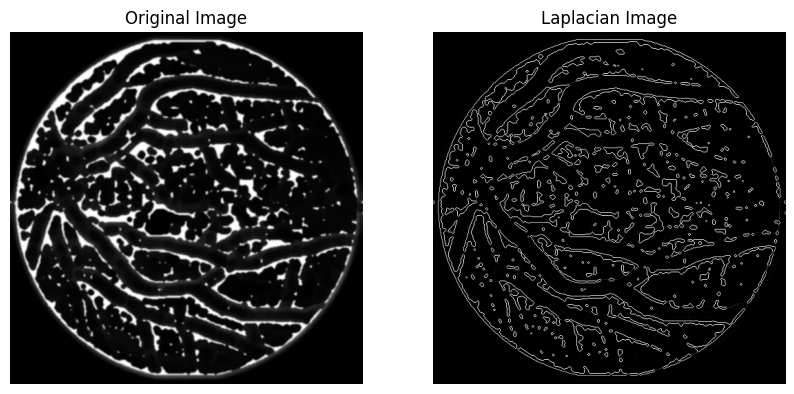

In [370]:

import cv2
# 定义Laplace算子的卷积核
laplace_kernel = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])

# 应用卷积操作
laplacian_image = cv2.filter2D(filtered_close, -1, laplace_kernel)

# 显示结果
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(denoised_vessel_only, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(laplacian_image, cmap='gray')
plt.title('Laplacian Image')
plt.axis('off')

plt.show()



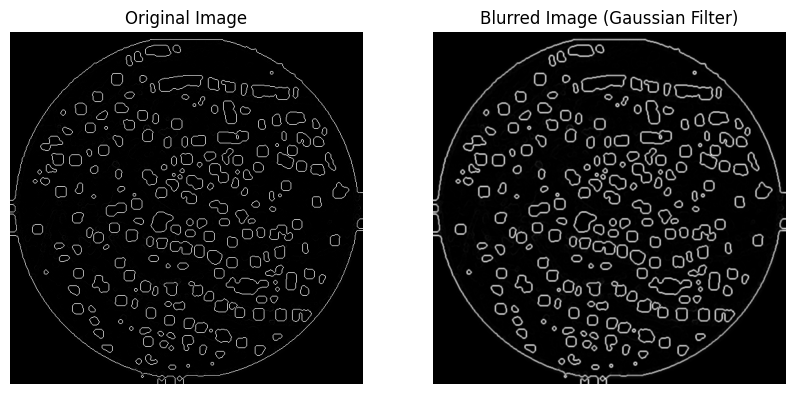

In [338]:
kernel_size = (3, 3)

# 使用高斯滤波器进行滤波
blurred_image = cv2.GaussianBlur(laplacian_image, kernel_size, sigmaX=0)

# 显示结果
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(laplacian_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(blurred_image, cmap='gray')
plt.title('Blurred Image (Gaussian Filter)')
plt.axis('off')

plt.show()

In [339]:
evaluate(blurred_image, img_GT)

(0.11354514617157357,
 0.5729030572249804,
 array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]))

In [340]:
import numpy as np
from skimage.morphology import erosion, dilation,binary_erosion, opening, closing, white_tophat, reconstruction, area_opening
from skimage.morphology import black_tophat, skeletonize, convex_hull_image,extrema
from skimage.morphology import square, diamond, octagon, rectangle, star, disk, label
from skimage.segmentation import watershed
from PIL import Image
from scipy import ndimage as ndi
from skimage.util import img_as_ubyte
from skimage import data, util, filters, color
import math
from skimage import io, color
from skimage import segmentation
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import torch
import torch.nn as nn
import torch.nn.functional as F
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries

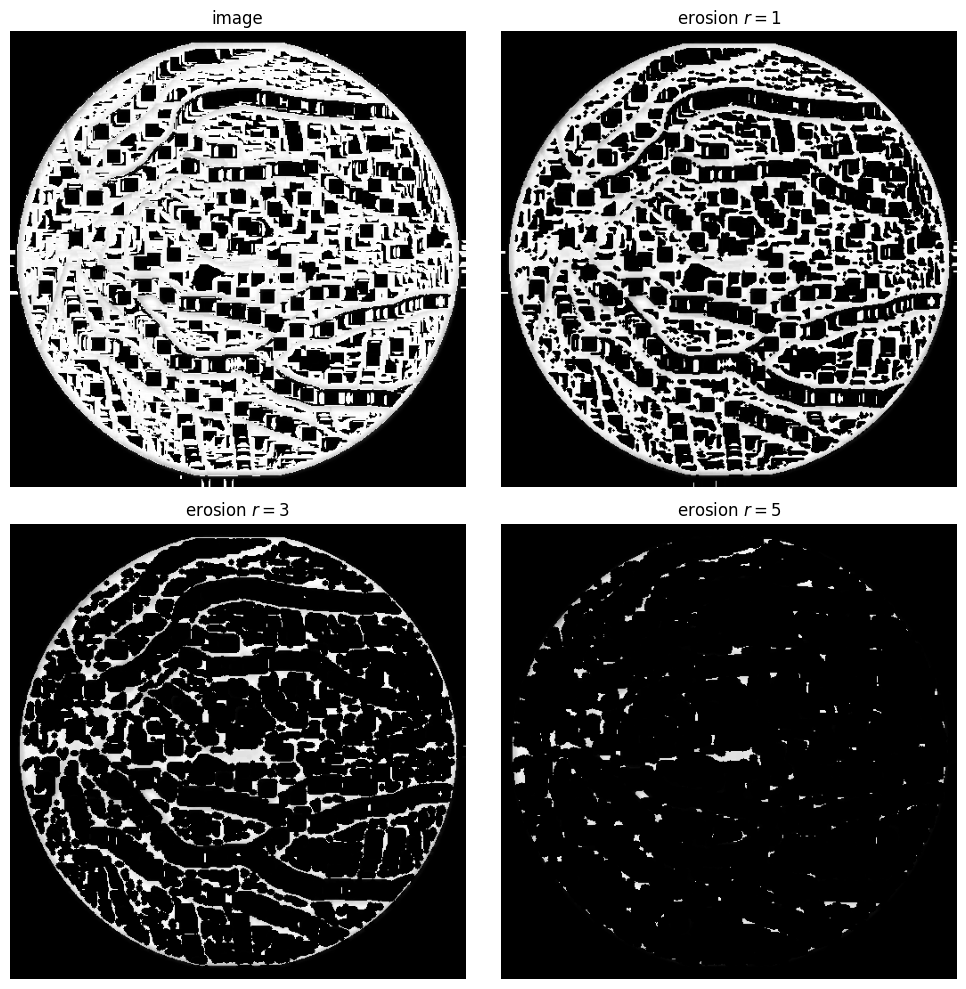

In [341]:
#imgGrad = dilation(lab[:,:,0], scale1[i]) - erosion(lab[:,:,0], scale1[i])

fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(vessel_only, vmin=0, vmax=255, cmap=plt.cm.gray)
ax[0].set_title('image')

ax[1].imshow(erosion(vessel_only, disk(1)), vmin=0, vmax=255, cmap=plt.cm.gray)
ax[1].set_title('erosion $r=1$')

ax[2].imshow(erosion(vessel_only, disk(3)), vmin=0, vmax=255, cmap=plt.cm.gray)
ax[2].set_title('erosion $r=3$')

ax[3].imshow(erosion(vessel_only, disk(5)), vmin=0, vmax=255, cmap=plt.cm.gray)
ax[3].set_title('erosion $r=5$')

for a in ax:
    a.axis('off')

plt.tight_layout()

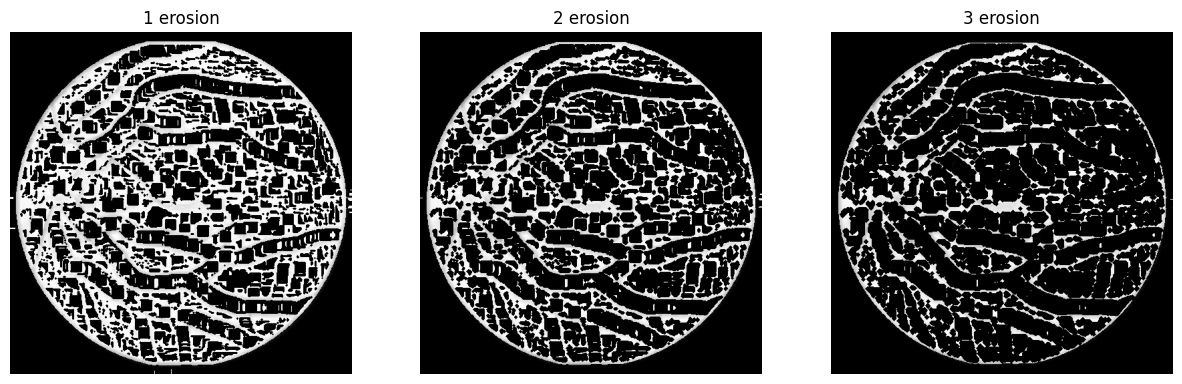

In [342]:
erosion1 = erosion(vessel_only, disk(1))
erosion2 = erosion(erosion1, disk(1))
erosion3 = erosion(erosion2, disk(1))
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(erosion1, cmap='gray')
plt.title('1 erosion')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(erosion2, cmap='gray')
plt.title('2 erosion')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(erosion3, cmap='gray')
plt.title('3 erosion')
plt.axis('off')
plt.show()

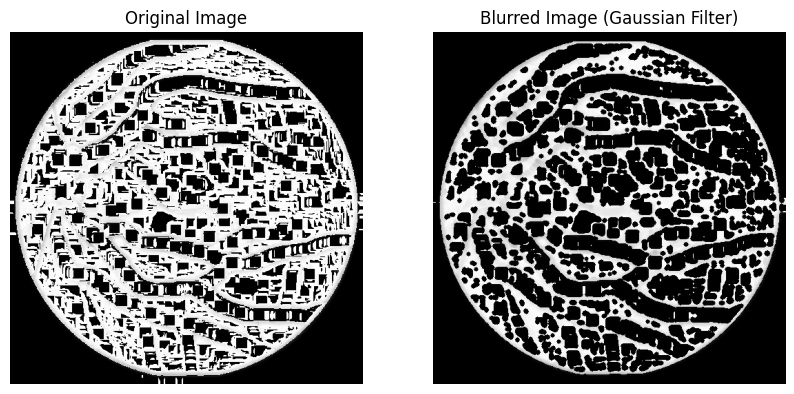

In [343]:
closing1 = closing(erosion2, disk(3))

# 显示结果
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(vessel_only, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(closing1, cmap='gray')
plt.title('Blurred Image (Gaussian Filter)')
plt.axis('off')

plt.show()

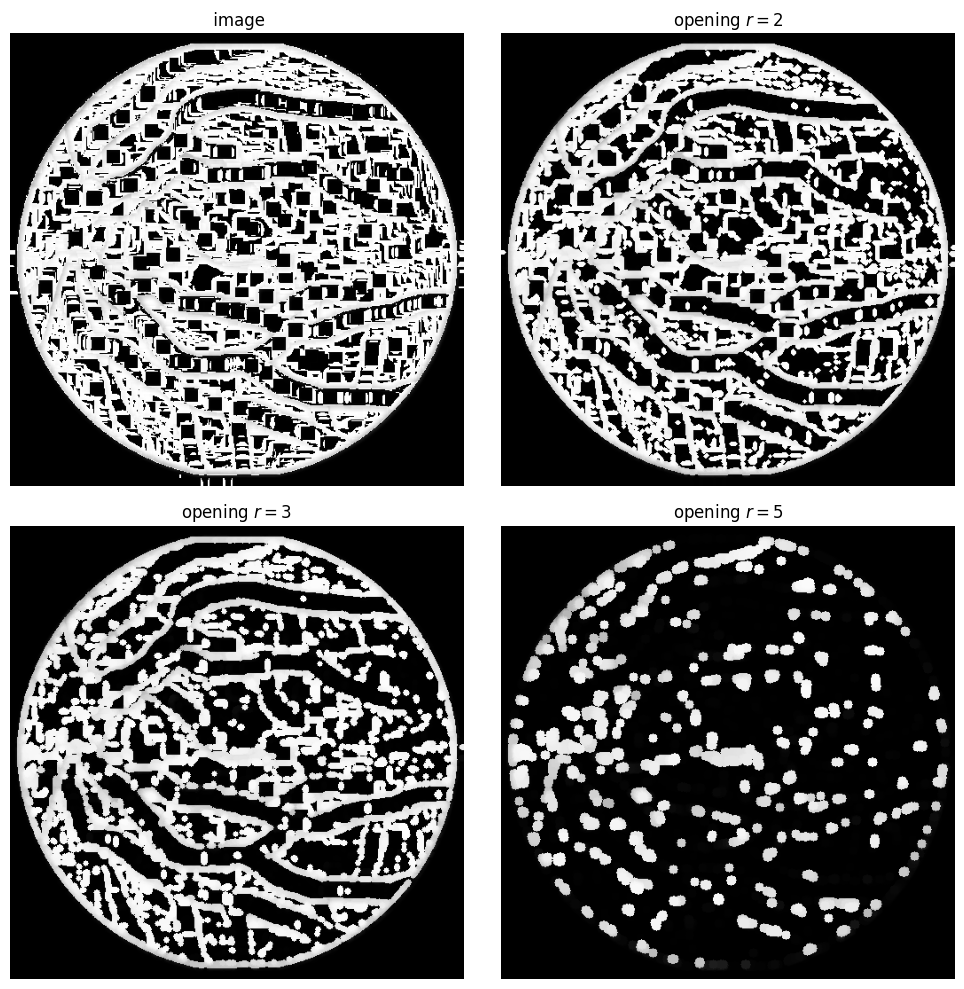

In [344]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(vessel_only, vmin=0, vmax=255, cmap=plt.cm.gray)
ax[0].set_title(' image')

ax[1].imshow(opening(vessel_only, disk(2)), vmin=0, vmax=255, cmap=plt.cm.gray)
ax[1].set_title('opening $r=2$')

ax[2].imshow(opening(vessel_only, disk(3)), vmin=0, vmax=255, cmap=plt.cm.gray)
ax[2].set_title('opening $r=3$')

ax[3].imshow(opening(vessel_only, disk(5)), vmin=0, vmax=255, cmap=plt.cm.gray)
ax[3].set_title('opening $r=5$')

for a in ax:
    a.axis('off')

plt.tight_layout()

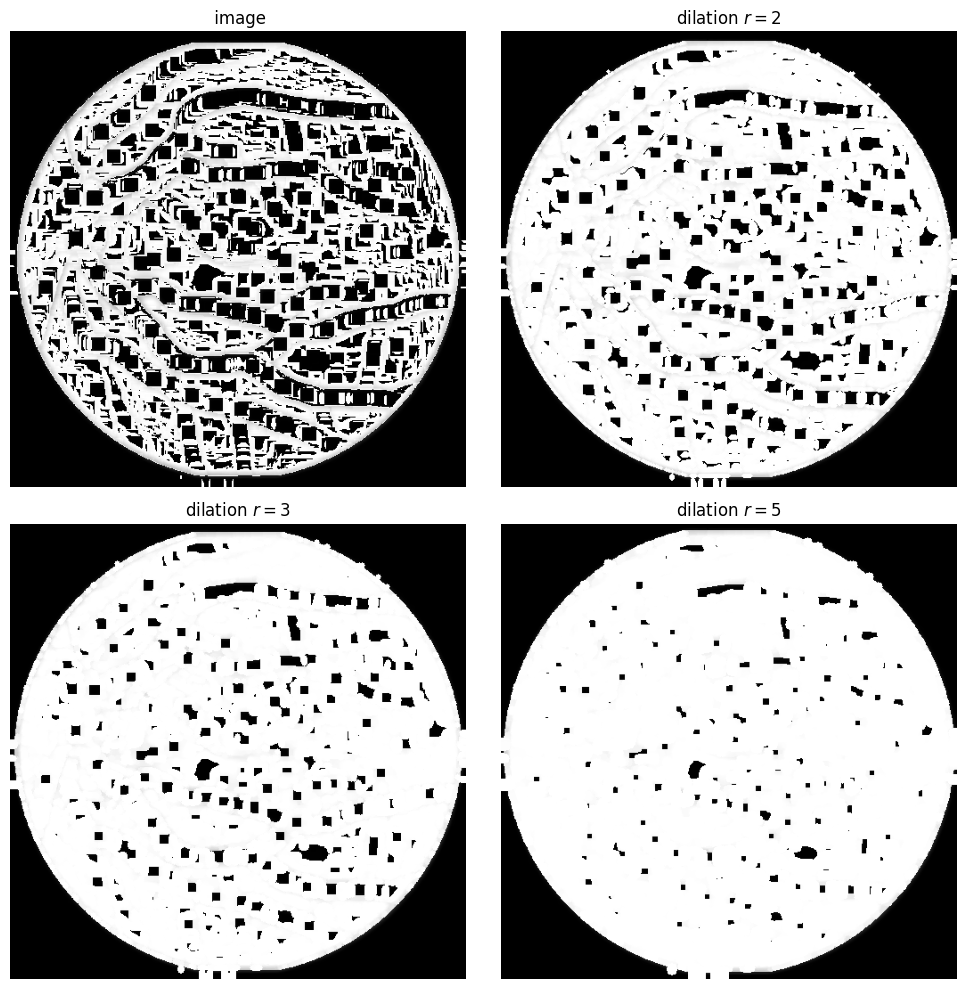

In [345]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(vessel_only, vmin=0, vmax=255, cmap=plt.cm.gray)
ax[0].set_title(' image')

ax[1].imshow(dilation(vessel_only, disk(2)), vmin=0, vmax=255, cmap=plt.cm.gray)
ax[1].set_title('dilation $r=2$')

ax[2].imshow(dilation(vessel_only, disk(3)), vmin=0, vmax=255, cmap=plt.cm.gray)
ax[2].set_title('dilation $r=3$')

ax[3].imshow(dilation(vessel_only, disk(5)), vmin=0, vmax=255, cmap=plt.cm.gray)
ax[3].set_title('dilation $r=5$')

for a in ax:
    a.axis('off')

plt.tight_layout()

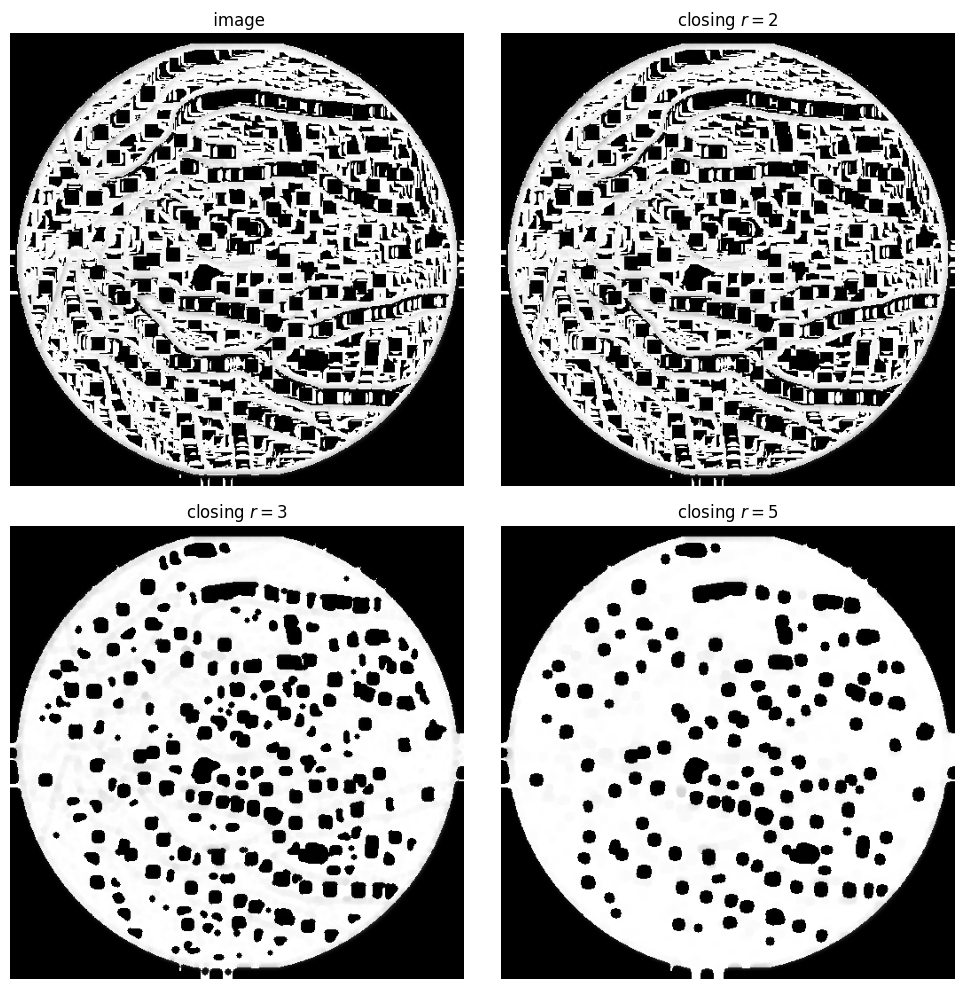

In [346]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(vessel_only, vmin=0, vmax=255, cmap=plt.cm.gray)
ax[0].set_title(' image')

ax[1].imshow(vessel_only, vmin=0, vmax=255, cmap=plt.cm.gray)
ax[1].set_title('closing $r=2$')

ax[2].imshow(closing(vessel_only, disk(3)), vmin=0, vmax=255, cmap=plt.cm.gray)
ax[2].set_title('closing $r=3$')

ax[3].imshow(closing(vessel_only, disk(5)), vmin=0, vmax=255, cmap=plt.cm.gray)
ax[3].set_title('closing $r=5$')

for a in ax:
    a.axis('off')

plt.tight_layout()